## 2.  Testing properties on networks
This notebook explores networks/graphs generated by notebook `1_LR_networks`
with the aim to check properties : connectiveness, cycles, stars.
-------------------------------
Author: johaGL

In [6]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import holoviews
import pygraphviz
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
import pickle
from networkx.drawing.nx_agraph import write_dot 
import copy

In [7]:
dx = pickle.load( open( "graphobjs/dictio_dx_filtered.p", "rb" ) )   # open filtered dictionary

In [8]:
dx.keys()

dict_keys(['Young', 'Old'])

In [9]:
dx['Young'].keys()

dict_keys(['D0', 'D2', 'D4', 'D7'])

In [10]:
type(dx['Young']['D2'])

networkx.classes.digraph.DiGraph

####  Exploring **Young** at day 2  

In [11]:
G = dx['Young']['D2']  

In [12]:
len(G.nodes())

1797

In [13]:
simcyc = list(nx.simple_cycles(G))

In [14]:
len(simcyc)  # number of cycles, all sizes included

187

In [15]:
l_cyc = []
for l in simcyc:
    if len(l) >= 2:
        tmp = sorted(list(set([i for i in l])))
        if tmp not in l_cyc:
            l_cyc.append(tmp)

In [16]:
print(len(l_cyc))

117


In [17]:
l_so_cyc = sorted(l_cyc, key=len, reverse=True)

In [18]:
print(l_so_cyc[4])

['Cadm1_M1', 'Cadm1_M2', 'Cadm3_ECs', 'Cadm3_FAPs', 'Crtam_Neutro']


In [19]:
subcyc = G.subgraph(l_so_cyc[4])

*TESTING A VISUAL REPRESENTATION USING NETWORKX AND PYPLOT TOOLS*

In [20]:
def rendercustom_fig(myG):
    nodes = myG.nodes()
    edges = myG.edges()
    ccc = [ i for i in nx.get_node_attributes(myG, 'color').values()]
    eee = [ i for i in nx.get_edge_attributes(myG, 'ecolor').values()]
    fig = plt.figure()
    pos = nx.spring_layout(myG, k=0.5)
    node_labels = nx.get_node_attributes(myG,'genesym')

    nodes = nx.draw_networkx_nodes(myG,
                                  pos,
                                  node_color = ccc, edgecolors = 'lightgray', 
                                  alpha=0.7)
    edges = nx.draw_networkx_edges(myG,
                                  pos,
                                  edge_color = eee, alpha=0.7)
    nx.draw_networkx_labels(myG, pos, labels=node_labels)
    ax = plt.gca()
    ax.set_axis_off()
    print(fig.tight_layout())
    return "fig finished"

None


'fig finished'

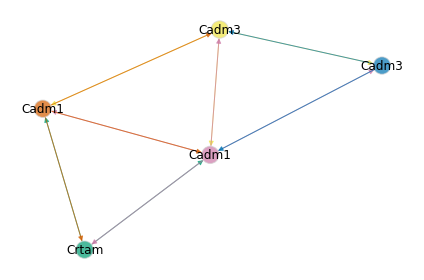

In [21]:
rendercustom_fig(subcyc)

**this was not a good representation, because arcs in oposite directions superpose !!. Better to use DOT (graphviz) representation*** 

In [18]:
from networkx.drawing.nx_agraph import write_dot 

write_dot(subcyc,'propertiesYoung/cycle_D2.dot') 

Recall: to open a dot file, save to png (in terminal): `$ dot -Tpng -O cycle_D2.dot`

### Check if there are any connected components
Keep graph directed. Here I use a modified algorithm of deep-first search see doc: 
 https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.strongly_connected_components.html?highlight=strongly_connected_component.
 
 <div></div>
 <div class="alert alert-warning">Note that `nx.connected_components()` function works only on UNDIRECTED graphs. For DIRECTED ones we can use `strongly_connected_components()` <a href="https://stackoverflow.com/questions/26105764/how-do-i-get-the-giant-component-of-a-networkx-graph">(info here)</a> </div> 
 
 

In [22]:
coco_sorted = sorted( nx.strongly_connected_components(G), key=len, reverse=True)

In [23]:
len([ i for i in coco_sorted if len(i) >= 3])

14

In [24]:
len(coco_sorted[0])

12

None


'fig finished'

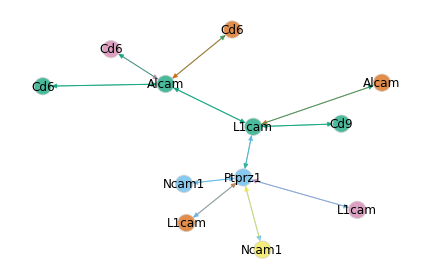

In [25]:
sub_coco  = G.subgraph(coco_sorted[0])
rendercustom_fig(sub_coco) 

it is more like several stars linked to each other. Save into dot file:

In [23]:
write_dot(sub_coco,'propertiesYoung/dir_compo_D2.dot')  #  to open: dot -Tpng -O filename

In [26]:
coco_sorted[2]

{'Cd22_M1',
 'Cd22_M2',
 'Mrc1_M1',
 'Mrc1_M2',
 'Ptprc_M1',
 'Ptprc_M2',
 'Ptprc_Neutro'}

None


'fig finished'

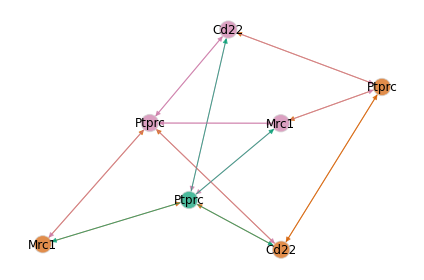

In [27]:
sub_coco_b = G.subgraph(coco_sorted[2])
rendercustom_fig(sub_coco_b)

In [26]:
write_dot(sub_coco_b,'propertiesYoung/dir_compo_D2_b.dot')  

Transform all dot into png :
```
$ cd propertiesYoung
$ for i in *; do dot -Tpng -O $i;done
```

<div class="alert alert-info">
    <strong>In summary, for these directed "graphs", connected components are very small size, which is expected from a L-R network (connections are mainly one-to-one). Moreover, in .dot generated files it is evident that cycles are generated due to the existence of an edge from A to B and another edge from B to A</strong> (being A and B any two different connected nodes in the network)
</div>

<div class="alert alert-block alert-danger">
<b>CAUTION:</b> our "graphs" are unconnected, we expect for each "graph" object ~ 1000 connected components, most of them being of very small size (two is the minimum size, i.e. one L-R pair where both nodes are not the same)
</div> 
 


--------------------------------------------
* testing with undirected


In [28]:
U = G.to_undirected()
co_u = sorted(nx.connected_components(U), key=len, reverse=True)
print(len([ i for i in co_u if len(i) >= 3]))


71


In [29]:
print(f"biggest component for undirected version has : {len(co_u[0])} nodes")

biggest component for undirected version has : 1355 nodes


In [35]:
print(f"in second place we found a component having: {len(co_u[1])} nodes")

in second place we found a component having: 36 nodes


Plot the second biggest undirected component (36 nodes)

None


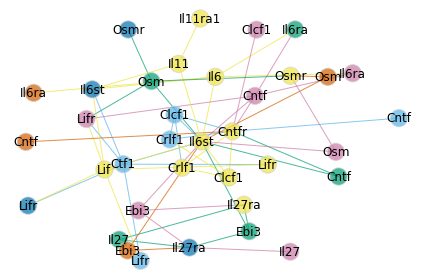

In [34]:
subU = U.subgraph(co_u[1])  
rendercustom_fig(subU)
write_dot(subU, 'propertiesYoung/undirected_D2_1.dot')


<div> We saw that for undirected version we do find a bigger connected component, but it seems to result from inter-connected "stars"</div> 


* end testing with undirected

---------------------------------------------------------



### Detecting HUBS
Using maximum degree nodes, we aim to find the "hubs" i.e. the nodes having highest connectivity. In Graph Theory this is called **"star"** type graph.

In [38]:
degrees = G.degree()
complete_degr = [(node, val) for (node, val) in degrees]
map(list, zip(*complete_degr))          # https://stackoverflow.com/questions/12974474/how-to-unzip-a-list-of-tuples-into-individual-lists
li0_li1 = [list(t) for t in zip(*complete_degr)] 
max(li0_li1[1])

42

In [39]:
maxindex = np.argmax(li0_li1[1])
li0_li1[0][maxindex]

'Fn1_FAPs'

In [40]:
iterne = G.neighbors(li0_li1[0][maxindex])
l_neigh = [i for i in iterne]
l_neigh.append(li0_li1[0][maxindex])

In [41]:
sub_hub1 = G.subgraph(l_neigh )

None


'fig finished'

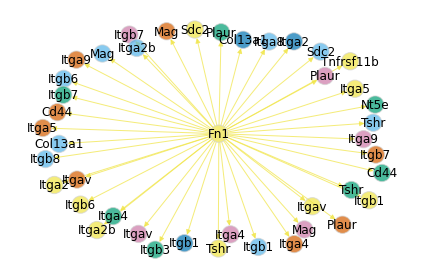

In [42]:
rendercustom_fig(sub_hub1)

This showed only outgoing arcs, we need incoming ones too (prececessors indeed)

In [43]:
sorted_degrees = copy.deepcopy(sorted(complete_degr, key = lambda x: x[1], reverse=True))
print(sorted_degrees[:10])


[('Fn1_FAPs', 42), ('Itgb3_Neutro', 36), ('Wnt5a_FAPs', 36), ('Itgb1_FAPs', 35), ('Egfr_FAPs', 35), ('Fgf2_FAPs', 30), ('Sele_ECs', 28), ('Lrp1_FAPs', 27), ('Col1a1_FAPs', 27), ('Mdk_sCs', 25)]


**Top 'Hubs' are found and visualized in next cell, scroll down to see plots**
Remember we are still exploring Young,D2

None
None
None
None
None
None
None
None
None
None


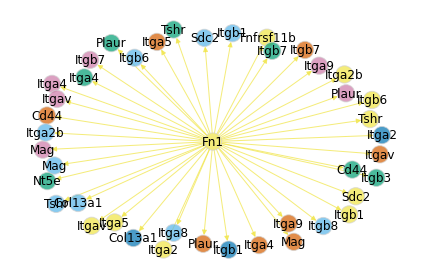

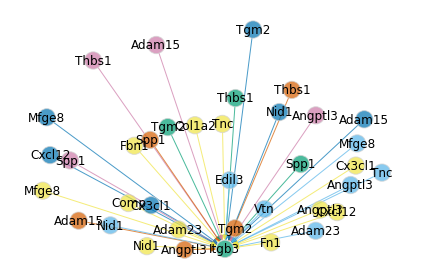

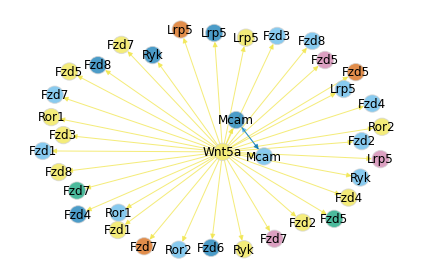

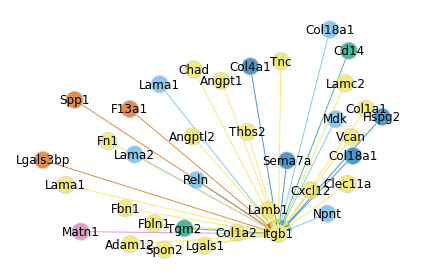

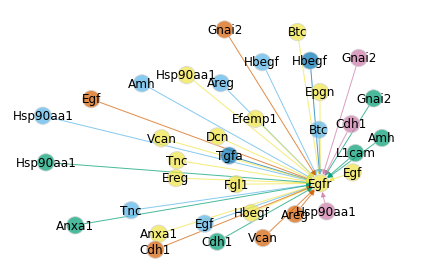

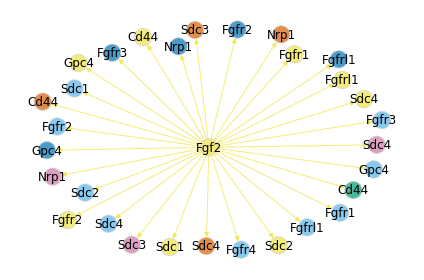

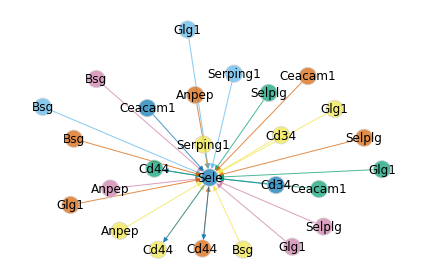

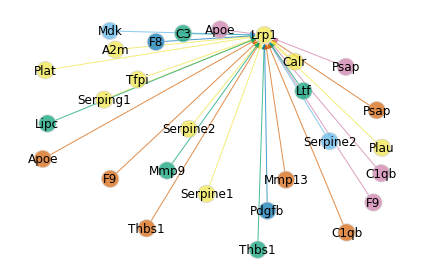

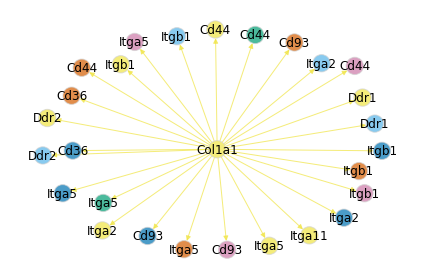

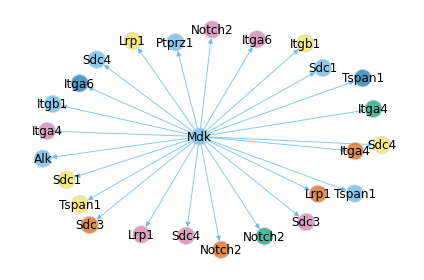

In [44]:
for tup_degree in sorted_degrees[:10]:
    name_hub = tup_degree[0]
    #print(name_hub)
    iter_out = G.neighbors(name_hub)  #all outcoming, sucessors
    iter_in = G.predecessors(name_hub) # all incoming
    l_out = [ i for i in iter_out ]
    l_in = [i for i in iter_in ]
    l_nei = copy.deepcopy(l_out)
    for i in l_in:
        l_nei.append(i)
    l_nei.append(name_hub)
    if len(l_nei) >= 10:
        subtmp = G.subgraph(l_nei)
        rendercustom_fig(subtmp)
                     
    

In [ ]:
## using depth-first traversal algorithm 'find_cycle' only returned: 
##   [[('Sele_ECs', 'Cd44_FAPs', 'forward'), ('Cd44_FAPs', 'Sele_ECs', 'forward')]]
#cyclesList = []
#try:
#    cyclesList.append(nx.find_cycle(G, orientation="original"))
#except:
#    pass


In [ ]:
# TODO: work centrality : https://necromuralist.github.io/data_science/posts/node-importance/
# https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-022-introduction-to-network-models-fall-2018/assignments/MIT1_022F18_Homework2.pdf

In [ ]:
# -----------------------------
# end johaGL
# note: in fedora to make pygraphviz work: 
# sudo yum install graphviz graphviz-devel